# OMAC STATE analysis

Find the running state of the machines.

Tags for Machines:

|IP_TAG Name   |Machine|
|--------------|-------|
|36630901_OMACSTATE|Assembly|
|36640901_RUN|Labeler|
|36650901_OMACSTATE|Packaging (Pacemaker!)|
|N/A|Cartoner|   
|N/A|Palletizer|    


In [3]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [7]:
import pandas as pd
import numpy as np
import os
from glob import iglob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# function to read in files we need into a generic df
def create_df_from_file(indir, infolder, infilesearch):
    folder = infolder
    path = os.path.join(indir, folder)


    df = []
    df_created = pd.DataFrame()

    # do a recursive search for the files now we have multiple dirs
    for filename in iglob(path + '/**/*' + infilesearch + '*', recursive=True):
        df = pd.read_csv(filename)
        df_created = df_created.append(df)

    return df_created

In [9]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

df_omac = create_df_from_file(dir_sanofi_share, folder, "_OMACSTATE" )

df_run = create_df_from_file(dir_sanofi_share, folder, "36640901_RUN" )






In [10]:
# convert dates to datetime format
df_omac['IP_TREND_TIME'] = pd.to_datetime(df_omac['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_omac.set_index('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_run['IP_TREND_TIME'] = pd.to_datetime(df_run['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_run.set_index('IP_TREND_TIME', inplace=True)

Tags for Machines:

|IP_TAG Name   |Machine|
|--------------|-------|
|36630901_OMACSTATE|Assembly|
|36640901_RUN|Labeler|
|36650901_OMACSTATE|Packaging (Pacemaker!)|
|N/A|Cartoner|   
|N/A|Palletizer|    

In [11]:
df_omac['Machine'] = ''
df_omac.loc[df_omac['Name'] == '36630901_OMACSTATE', 'Machine'] = 'Assembly'
df_omac.loc[df_omac['Name'] == '36650901_OMACSTATE', 'Machine'] = 'Packaging'

df_run['Machine'] = ''
df_run.loc[df_run['Name'] == '36640901_RUN', 'Machine'] = 'Labeler'


OMAC State

|State|Mode|
|-----|----|
|0|Undefined|
|8|aborting|
|9|aborted|
|1|clearing|
|3|Setup|
|16|Basic|
|7|stopping|
|17|ChangeOver|
|2|stopped| 
|18|Cleaning|
|15|resetting|
|4|idle|
|3|starting|
|6|execute|
|13|suspending|
|5|suspended|
|14|unsuspending|
|10|holding|
|11|held|
|12|unholding|
|16|completing|
|17|complete|

In [12]:
# loop through the machines, sort the datetime index, and fine the time diff, write it out as secs (rather than leaving it as timedelta)
machines = df_omac.Machine.unique()

for x in machines:
    # df_omac['Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds
    df_omac.loc[df_omac.Machine == x, 'Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds

In [13]:
df_omac[df_omac['Time_Diff_Secs'].isna()]

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,
2021-08-01 00:03:09.500,36630901_OMACSTATE,2,Good,Good,Assembly,NaN
2021-08-01 00:28:22.500,36650901_OMACSTATE,15,Good,Good,Packaging,NaN
2021-08-01 00:28:22.500,36650901_OMACSTATELOW,15,Good,Good,,NaN


In [14]:
df_omac_unstacked = df_omac.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum().unstack().reset_index()
df_omac_unstacked.set_index('IP_TREND_TIME', inplace=True)
df_omac_unstacked

IP_TREND_VALUE,Machine,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,18,19,23
IP_TREND_TIME,,,,,,,,,,,,,,,,,,,,,
2021-08-01,,NaN,NaN,1165.0,NaN,398.0,NaN,242.0,8534.0,4.0,...,NaN,NaN,NaN,NaN,NaN,5661.0,6.0,NaN,NaN,NaN
2021-08-02,,NaN,NaN,39751.0,NaN,1750.0,NaN,724.0,18767.0,NaN,...,NaN,NaN,NaN,NaN,NaN,7427.0,71.0,NaN,NaN,NaN
2021-08-03,,NaN,NaN,6582.0,NaN,6733.0,NaN,1930.0,47679.0,5.0,...,NaN,NaN,NaN,NaN,NaN,22640.0,12.0,NaN,NaN,NaN
2021-08-04,,NaN,NaN,9347.0,NaN,6498.0,NaN,1422.0,49580.0,10.0,...,NaN,NaN,NaN,NaN,NaN,18855.0,35.0,NaN,NaN,NaN
2021-08-05,,NaN,NaN,10944.0,NaN,2132.0,NaN,2843.0,45943.0,15.0,...,NaN,NaN,NaN,NaN,NaN,24003.0,226.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,Packaging,4974.0,NaN,727.0,NaN,450.0,NaN,256.0,3562.0,6.0,...,NaN,NaN,NaN,NaN,NaN,6136.0,32.0,NaN,NaN,NaN
2021-09-27,Packaging,NaN,NaN,4081.0,NaN,1150.0,NaN,1133.0,40436.0,NaN,...,NaN,NaN,NaN,NaN,NaN,16454.0,NaN,NaN,NaN,NaN
2021-09-28,Packaging,NaN,NaN,10964.0,NaN,10069.0,NaN,1728.0,30394.0,44.0,...,NaN,NaN,NaN,NaN,NaN,31879.0,215.0,NaN,NaN,NaN


In [15]:
# not sure whether to change the state codes to categories/labels - might lose some use for numbers later

df_omac_unstacked.rename(columns={
0:'0 Undefined',
8:'8 aborting',
9:'9 aborted',
1:'1 clearing',
3:'3 Setup',
16:'16 Basic',
7:'7 stopping',
17:'17 ChangeOver',
2:'2 stopped', 
18:'18 Cleaning',
15:'15 resetting',
4:'4 idle',
3:'3 starting',
6:'6 execute',
13:'13 suspending',
5:'5 suspended',
14:'14 unsuspending',
10:'10 holding',
11:'11 held',
12:'12 unholding',
16:'16 completing',
17:'17 complete'
}, inplace=True)

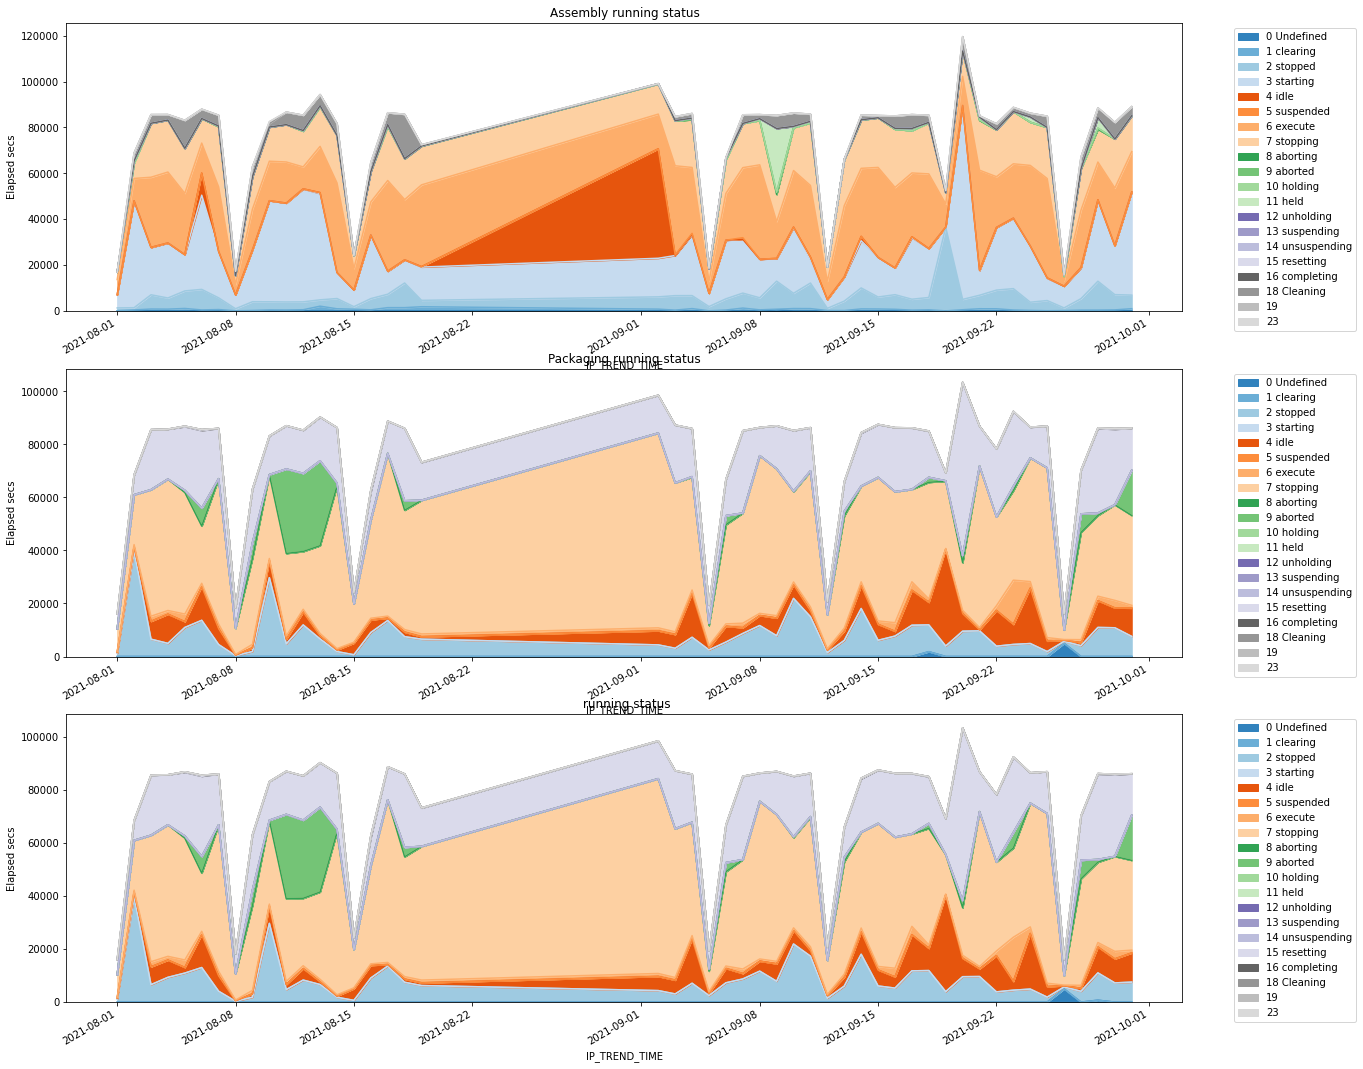

In [20]:
freq='1min'

fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

i=0
for x in machines:
    # group[group.Machine == x].hist(label=('{}'.format(x)), ax=axs[i])
    df_omac_unstacked[df_omac_unstacked.Machine == x].plot.area(ax=axs[i], cmap='tab20c')
    axs[i].set_title('{} running status'.format(x))
    axs[i].set_ylabel('Elapsed secs')
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.16, 1.0))
    i+=1


In [21]:
df_run['Time_Diff_Secs'] = df_run.index.sort_values().to_series().diff().dt.seconds

df_run_unstacked = df_run.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum().unstack().reset_index()
df_run_unstacked.set_index('IP_TREND_TIME', inplace=True)
df_run_unstacked

IP_TREND_VALUE,Machine,0,1
IP_TREND_TIME,,,
2021-08-01,Labeler,80125.0,5640.0
2021-08-02,Labeler,74682.0,11428.0
2021-08-03,Labeler,52427.0,33600.0
2021-08-04,Labeler,57844.0,28743.0
2021-08-05,Labeler,58831.0,26933.0
2021-08-06,Labeler,70227.0,16125.0
2021-08-07,Labeler,54275.0,31843.0
2021-08-08,Labeler,79328.0,7415.0
2021-08-09,Labeler,61326.0,24405.0


<AxesSubplot:title={'center':'Labeler running status'}, xlabel='IP_TREND_TIME', ylabel='Elapsed secs'>

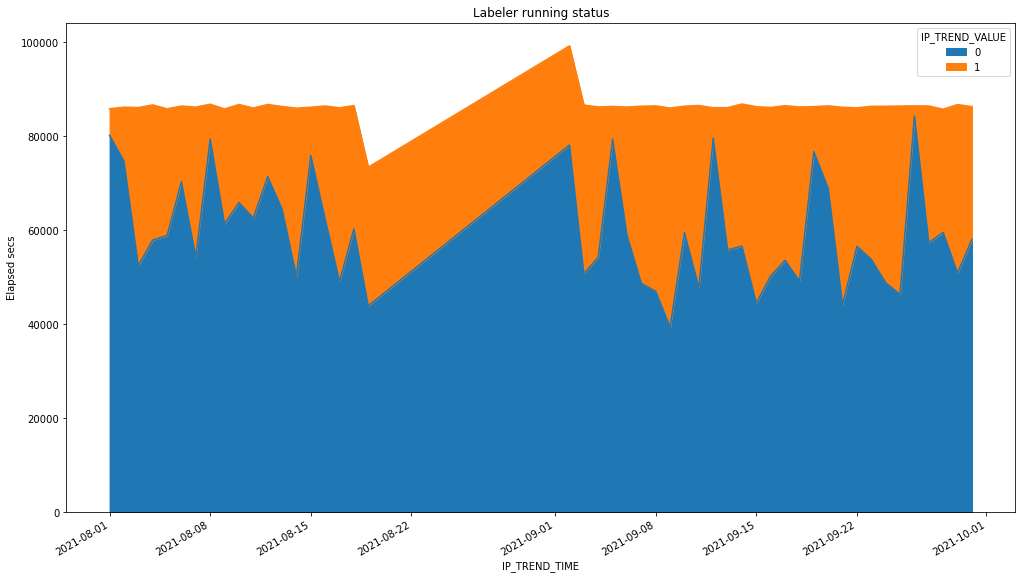

In [22]:
df_run_unstacked.plot.area(figsize=(17,10), 
title=('Labeler running status'),
ylabel=('Elapsed secs'))

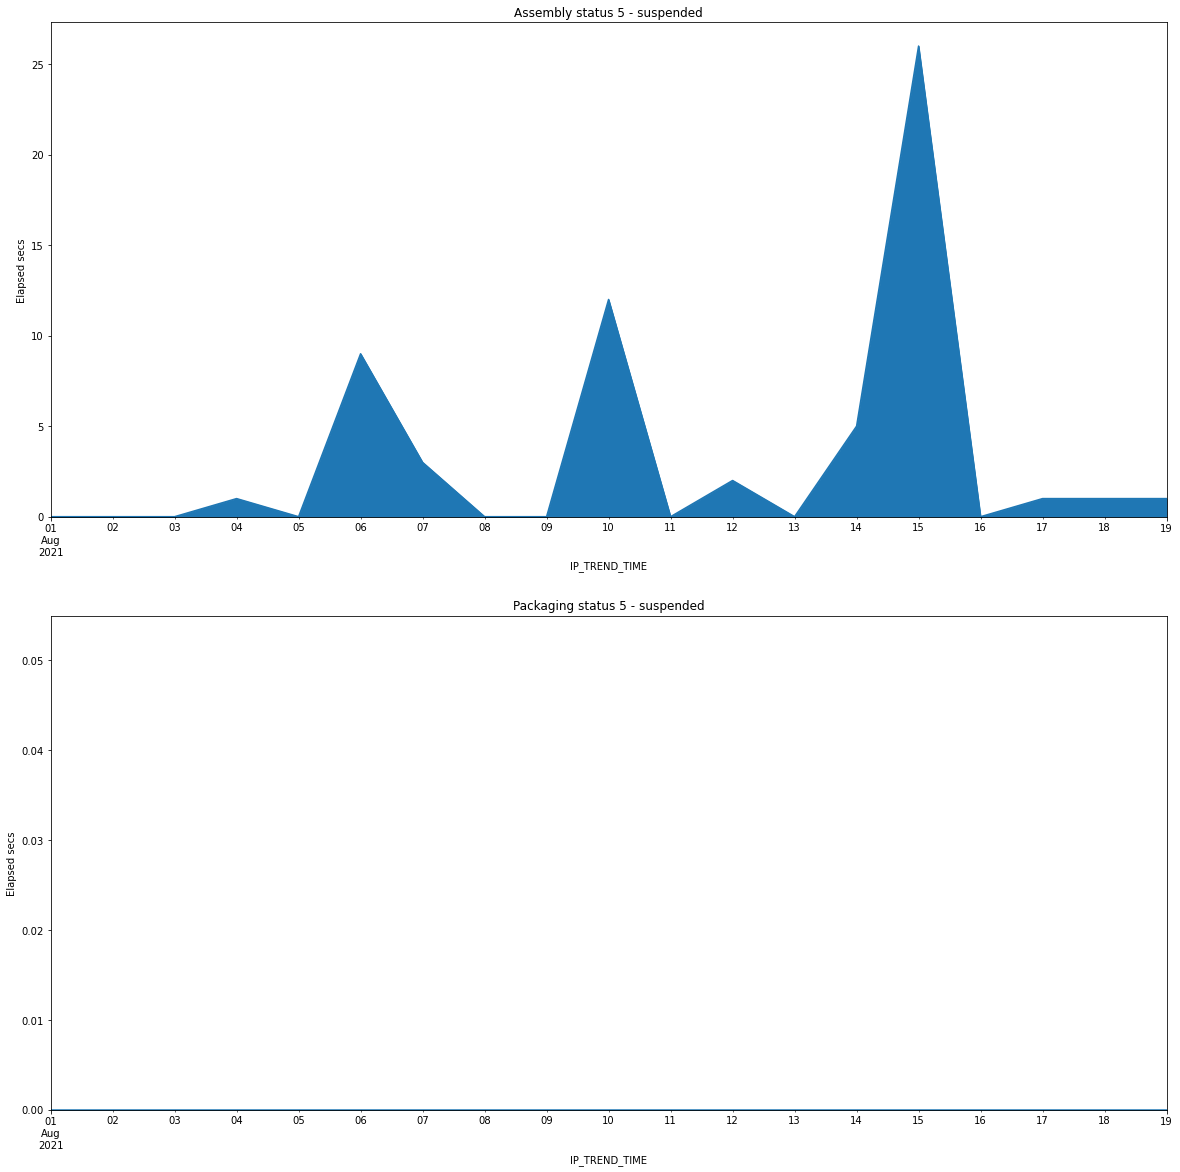

In [65]:
fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

i=0
for x in machines:
    # group[group.Machine == x].hist(label=('{}'.format(x)), ax=axs[i])
    df_omac_unstacked[(df_omac_unstacked.Machine == x)]['5 suspended'].plot.area(ax=axs[i])
    axs[i].set_title('{} status 5 - suspended'.format(x))
    axs[i].set_ylabel('Elapsed secs')
    i+=1


In [49]:
df_omac[df_omac.IP_TREND_VALUE == 5].groupby(['Machine','IP_TREND_VALUE']).sum()

,,Time_Diff_Secs
Machine,IP_TREND_VALUE,
Assembly,5,61.0


In [64]:
df_omac[df_omac.Machine == 'Assembly'].sort_index()

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,,
2021-08-01 00:03:09.500,36630901_OMACSTATE,2,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,NaN
2021-08-01 00:27:55.900,36630901_OMACSTATE,3,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,1486.0
2021-08-01 00:27:57.000,36630901_OMACSTATE,18,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,1.0
2021-08-01 00:28:04.200,36630901_OMACSTATE,6,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,7.0
2021-08-01 00:28:55.300,36630901_OMACSTATE,7,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,51.0
...,...,...,...,...,...,...,...
2021-08-19 20:19:04.700,36630901_OMACSTATE,7,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,2.0
2021-08-19 20:19:15.000,36630901_OMACSTATE,6,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,10.0
2021-08-19 20:19:16.000,36630901_OMACSTATE,7,Good,Good,tabIP21Data_36630901_OMACSTATE.csv,Assembly,1.0


In [31]:
df_run.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum()

Machine  IP_TREND_TIME  IP_TREND_VALUE
Labeler  2021-08-01     0                 80125.0
                        1                  5640.0
         2021-08-02     0                 74682.0
                        1                 11428.0
         2021-08-03     0                 52427.0
                        1                 33600.0
         2021-08-04     0                 57844.0
                        1                 28743.0
         2021-08-05     0                 58831.0
                        1                 26933.0
         2021-08-06     0                 70227.0
                        1                 16125.0
         2021-08-07     0                 54275.0
                        1                 31843.0
         2021-08-08     0                 79328.0
                        1                  7415.0
         2021-08-09     0                 61326.0
                        1                 24405.0
         2021-08-10     0                 65821.0
           